# Exploratory Data Analysis

In this EDA, I will be examining various data sources from [opendata.vancouver.ca](https://opendata.vancouver.ca/pages/home/).

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import requests
import os
import time
import pickle
import json
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import coalesce, max

In [3]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when, last, first, regexp_extract
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.types import *

## Reading in the main dataset

In [4]:
spark = SparkSession.builder.appName('Ops').getOrCreate()

In [5]:
# allows for cleaner output
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

> This creates a Spark DataFrame which is very similar to a Pandas DataFrame. Spark DataFrames build on top of RDDs and also has great SQL integration for users who are familiar with the popular language. The main difference with Spark DataFrames is that operations can run on multiple nodes and they are lazy evaluators meaning operations won't be executed until the output is needed.

In [6]:
licences_df = (spark.read
          .option('header','true')
          .option('inferSchema','true')
          .option('sep', ';')
          .csv('../data/business-licences.csv'))

In [7]:
f'There are %i observations in this dataset' % licences_df.count() 

'There are 504842 observations in this dataset'

In [8]:
licences_df.printSchema()

root
 |-- FOLDERYEAR: integer (nullable = true)
 |-- LicenceRSN: integer (nullable = true)
 |-- LicenceNumber: string (nullable = true)
 |-- LicenceRevisionNumber: integer (nullable = true)
 |-- BusinessName: string (nullable = true)
 |-- BusinessTradeName: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- IssuedDate: timestamp (nullable = true)
 |-- ExpiredDate: timestamp (nullable = true)
 |-- BusinessType: string (nullable = true)
 |-- BusinessSubType: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- House: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- LocalArea: string (nullable = true)
 |-- NumberofEmployees: double (nullable = true)
 |-- FeePaid: integer (nullable = true)
 |-- ExtractDate: timestamp (nullable = true)
 |-- Geom: st

In [7]:
licences_df = licences_df.withColumnRenamed('FOLDERYEAR', 'year')\
           .withColumnRenamed('LicenceRSN', 'licence_rsn')\
           .withColumnRenamed('LicenceNumber', 'licence_num')\
           .withColumnRenamed('LicenceRevisionNumber', 'licence_revision_num')\
           .withColumnRenamed('BusinessName', 'owner_name')\
           .withColumnRenamed('BusinessTradeName', 'name')\
           .withColumnRenamed('Status', 'status')\
           .withColumnRenamed('IssuedDate', 'issued_date')\
           .withColumnRenamed('ExpiredDate', 'expired_date')\
           .withColumnRenamed('BusinessType', 'type')\
           .withColumnRenamed('BusinessSubType', 'subtype')\
           .withColumnRenamed('Unit', 'unit')\
           .withColumnRenamed('UnitType', 'unit_type')\
           .withColumnRenamed('House', 'house')\
           .withColumnRenamed('Street', 'street')\
           .withColumnRenamed('City', 'city')\
           .withColumnRenamed('Province', 'province')\
           .withColumnRenamed('Country', 'country')\
           .withColumnRenamed('PostalCode', 'postal_code')\
           .withColumnRenamed('LocalArea', 'area')\
           .withColumnRenamed('NumberofEmployees', 'n_employees')\
           .withColumnRenamed('FeePaid', 'fee')\
           .withColumnRenamed('ExtractDate', 'extract_date')\
           .withColumnRenamed('Geom', 'geom')

In [308]:
# show the first 10 rows 
licences_df.limit(10)

year,licence_rsn,licence_num,licence_revision_num,owner_name,name,status,issue_date,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,geom
15,2345113,15-115406,0,(Shun Chen),ACC Security Syst...,Gone Out of Business,null,null,Electrical-Securi...,null,null,null,null,null,Surrey,BC,CA,null,null,2.0,null,2019-07-21 13:48:02,null
15,2345119,15-115412,0,Praetorian Securi...,Amax Praetorian,Issued,2014-12-01 14:04:29,2015-12-31 00:00:00,Electrical-Securi...,null,null,null,null,null,Chilliwack,BC,CA,null,null,0.0,133,2019-07-21 13:48:02,null
15,2345120,15-115413,0,Safe-Tec Security...,null,Gone Out of Business,null,null,Electrical-Securi...,null,null,null,null,null,Surrey,BC,CA,null,null,0.0,null,2019-07-21 13:48:02,null
15,2345121,15-115414,0,Husky Alarm Integ...,null,Issued,2015-02-10 08:05:11,2015-12-31 00:00:00,Electrical-Securi...,null,null,null,null,null,Port Moody,BC,CA,null,null,2.0,173,2019-07-21 13:48:02,null
15,2345122,15-115415,0,Sea to Sky Securi...,null,Pending,null,null,Electrical-Securi...,null,null,null,null,null,North Vancouver,BC,CA,null,null,3.0,null,2019-07-21 13:48:02,null
15,2345188,15-115481,0,(Kenneth Bradley),Ken Bradley Truck...,Issued,2014-11-18 11:35:48,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Coquitlam,BC,CA,null,null,0.0,162,2019-07-21 13:48:02,null
15,2345191,15-115484,0,Litz Crane Servic...,null,Issued,2014-11-06 14:31:00,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Port Coquitlam,BC,CA,null,null,5.0,162,2019-07-21 13:48:02,null
15,2345195,15-115488,0,(Wayne Nichols),W Nichols Trucking,Issued,2014-11-05 12:50:58,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Delta,BC,CA,null,null,1.0,162,2019-07-21 13:48:02,null
15,2345196,15-115489,0,(Harry Powar),Harry Powar Trucking,Issued,2014-12-04 18:49:08,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Burnaby,BC,CA,null,null,1.0,162,2019-07-21 13:48:02,null
15,2345203,15-115496,0,J Brown Trucking Inc,null,Issued,2014-12-06 09:23:32,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Delta,BC,CA,null,null,2.0,162,2019-07-21 13:48:02,null


In [291]:
licences_df.groupBy('year').count()

year,count
13,60915
16,61394
20,64003
19,70771
15,60938
17,60060
14,60581
18,66180


## Initial Wrangling 

In [8]:
business_types = licences_df.select('type').distinct().collect()
business_list = [business_types[i].type for i in range(len(business_types))]

r = re.compile(".*[Ff]ood.*|.*[Rr]estaurant.*|.*[Ll]iquor.*")
relevant_list = list(filter(r.match, business_list)) 
print(relevant_list)

['Manufacturer - Food with Anc. Retail', 'Ltd Service Food Establishment', 'Temp Liquor Licence Amendment', 'Liquor Delivery Services', 'Liquor Establishment Standard', 'Retail Dealer - Food', 'Restaurant Class 2', 'Food Processing', 'Liquor Establishment Extended', 'Wholesale Dealer - Food with Anc. Retail', 'Restaurant Class 1', 'Liquor License Application', 'Warehouse Operator - Food', 'Manufacturer - Food', 'Liquor Retail Store', 'Wholesale Dealer - Food']


> These are the list of business types that have the word food, restaurant, or liquor.

In [9]:
rest_1 = (licences_df.type == 'Restaurant Class 1')
rest_2 = (licences_df.type == 'Restaurant Class 2')
rest_3 = (licences_df.type == 'Ltd Service Food Establishment')
rest_4 = (licences_df.type == 'Temp Liquor Licence Amendment') & (licences_df.subtype == 'Area Extension')
rest_5 = (licences_df.type == 'Liquor Establishment Standard') & (licences_df.subtype == 'Class 1  0-65 Seats')
rest_6 = (licences_df.type == 'Liquor Establishment Extended') & (licences_df.subtype == 'Class 1  0-65 Seats')


licences_rest_df = licences_df.filter(rest_1 | rest_2 | rest_3 | rest_4 | rest_5 | rest_6)

In [10]:
licences_rest_df.groupBy("status").count()

status,count
Cancelled,604
Gone Out of Business,2914
Issued,24579
Inactive,662
Pending,1420


In [312]:
f'There are %i businesses with missing name values' % licences_rest_df.filter('name is null').select('owner_name').distinct().count()

'There are 955 businesses with missing name values'

> I will replace these entries with their business names. 

In [11]:
licences_rest_df = licences_rest_df.withColumn('name', coalesce('name', 'owner_name'))

In [12]:
licences_rest_df = licences_rest_df.dropna(subset = ['owner_name'])

In [13]:
# create new columns for longitude and latitude
licences_rest_df = licences_rest_df.withColumn('longitude', regexp_extract(col('geom'), '\[(.+), (.+)\]', 1).cast('float'))\
                                   .withColumn('latitude', regexp_extract(col('geom'), '\[(.+), (.+)\]', 2).cast('float'))\
                                   .drop('geom')

In [383]:
licences_rest_df.count()

30148

In [62]:
# Search for names using regex

def search_restaurant(search_term, n = 20):
    rows = licences_rest_df.name.rlike('.*{}.*'.format(search_term))
    return licences_rest_df.filter(rows).limit(n)

In [64]:
search_restaurant("Turk's Coffee House", 5)

year,licence_rsn,licence_num,licence_revision_num,owner_name,name,status,issued_date,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,longitude,latitude
16,2584151,16-125333,0,Brian Turko & Lin...,Turk's Coffee House,Issued,2016-01-31 13:58:05,2016-12-31 00:00:00,Ltd Service Food ...,null,null,null,1276,Commercial Dr,Vancouver,BC,CA,V5L 3X4,Grandview-Woodland,7.0,542,2019-07-21 13:49:19,null,null
13,1796918,13-177499,0,Brian Turko & Lin...,Turk's Coffee House,Issued,2012-12-31 14:00:53,2013-12-31 00:00:00,Ltd Service Food ...,null,null,null,1276,Commercial Dr,Vancouver,BC,CA,V5L 3X4,Grandview-Woodland,7.0,469,2019-07-21 13:49:07,null,null
15,2355590,15-125876,0,Brian Turko & Lin...,Turk's Coffee House,Issued,2014-10-31 15:52:55,2015-12-31 00:00:00,Ltd Service Food ...,null,null,null,1276,Commercial Dr,Vancouver,BC,CA,V5L 3X4,Grandview-Woodland,7.0,483,2019-07-21 13:49:15,null,null
17,2800337,17-124040,0,Brian Turko & Lin...,Turk's Coffee House,Issued,2016-12-23 11:42:28,2017-12-31 00:00:00,Ltd Service Food ...,null,null,null,1276,Commercial Dr,Vancouver,BC,CA,V5L 3X4,Grandview-Woodland,7.0,503,2020-01-01 02:32:03,null,null
14,2138220,14-125810,0,Brian Turko & Lin...,Turk's Coffee House,Issued,2013-12-31 14:05:50,2014-12-31 00:00:00,Ltd Service Food ...,null,null,null,1276,Commercial Dr,Vancouver,BC,CA,V5L 3X4,Grandview-Woodland,7.0,474,2019-07-21 13:49:11,null,null


In [344]:
# number of missing values of each column
licences_rest_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in licences_rest_df.columns))

year,licence_rsn,licence_num,licence_revision_num,name,trade_name,status,IssuedDate,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,geom
0,0,0,0,0,0,0,3261,3260,0,12929,25242,25238,17,17,0,0,2,243,87,0,2537,0,831


In [17]:
# use this table to populate the features from yelp

rest_distinct_df = licences_rest_df.select(['year', 'status', 
                                            'name', 'longitude', 'latitude', 
                                            'postal_code', 'unit', 'house', 
                                            'street', 'city']).distinct()

In [18]:
f'There are %i restaurant locations' % licences_rest_df.select(['longitude', 'latitude', 'postal_code', 'unit', 
                                                                'house', 'street', 'city']).distinct().count()

'There are 4504 restaurant locations'

In [19]:
f'There are %i closed/open restaurants locations' % licences_rest_df.select(['name', 'longitude', 'latitude', 'postal_code', 
                                                                             'unit', 'house', 'street', 'city']).distinct().count()

# this includes restuarants that changed locations

'There are 6637 closed/open restaurants locations'

In [285]:
rest_distinct_df.filter('house is null')\
                .filter('street is null')\
                .select('trade_name')\
                .distinct()

trade_name
Fresh Counter & C...
Siga-Siga's Chine...
Siga-Siga's Filip...
Panz Veggie
Craft Beer Market...
Fiery Pizza


> The Yelp API requires an address of these restaurants and 6 restaurants do not have any address. Since this is an insignificant proportion of the data, I will simply remove them.

In [20]:
rest_distinct_df = rest_distinct_df.dropna(how = 'all', subset = ['longitude', 'latitude', 'house', 'street'])

> Problem: can't get information for old closed restuarants 
> - initial thoughts: have to find an external API that has archived webpages
> - maybe a solution: businesses/search doesn't give closed restuarants but businesses/matches does (have to have exact address) and then get the ID from this output and input into businesses/{id}

In [21]:
# Here I am ordering the status such that if in a single year, there are multiple statuses, I will take the greatest

rest_distinct_df = rest_distinct_df.withColumn('status', 
                            when(col('status') == 'Inactive', 0)
                            .when(col('status') == 'Cancelled', 1)
                            .when(col('status') == 'Gone Out of Business', 2)
                            .when(col('status') == 'Pending', 3)
                            .when(col('status') == 'Issued', 4))

In [22]:
# This will get the latest location of a restaurant
# if in a single year, the restuarant is both cancelled and gone out of businesss, aggregate into 1 category
# if in a single year, the restuarant is both cancelled and issued, aggregate into 1 category - this means the restuarant moved locations
latest_year = rest_distinct_df.sort(['year', 'status'])\
                              .groupBy('name')\
                              .agg(last('status').alias('status'), 
                                   last('year').alias('year'))

rest_distinct_df = rest_distinct_df.join(latest_year, on = ['status', 'year', 'name'], how = 'leftsemi')

In [323]:
rest_distinct_df.count()

5740

In [325]:
rest_distinct_df.limit(5)

status,year,name,postal_code,unit,house,street,city,longitude,latitude
1,17,George Simnos & J...,V5V 4E9,null,4153,FRASER ST,Vancouver,-123.09054,49.248013
2,15,Sodexo @Vancouver...,V5T 4V5,null,1120,E 7TH AV,Vancouver,-123.08036,49.2633
2,16,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,Vancouver,-123.121574,49.281162
2,17,O-Bowl,V6K 2H3,null,3132,W BROADWAY,Vancouver,-123.17483,49.26392
2,17,Swiss Chalet Roti...,V6K 2H4,null,3204,W BROADWAY,Vancouver,-123.176216,49.26395


Is the restaurant part of a chain?  
How many other restaurants are nearby (within one mile)?  
How does it compare to nearby restaurants (based on price, but also its average rating — and the number of reviews)?  
How old is the restaurants?

## Yelp API

In [480]:
rest_distinct_list = rest_distinct_df.collect()

In [513]:
def get_params(rest):
    """
    """
    
    name = rest.name
    
    house = rest.house
    street = rest.street
    if rest.unit == None:
        unit = ''
    else:
        unit = rest.unit
    address = ' '.join([unit, house, street])
    
    if rest.postal_code == None:
        postal_code = ''
    else:
        postal_code = rest.postal_code
            
    if rest.latitude == None:
        latitude = None
        longitude = None
    else:    
        latitude = rest.latitude
        longitude = rest.longitude
        
    city = rest.city
    
    return {'apikey': api_key,
            'name': name,
            'address1': address,
            'zip_code': postal_code,
            'latitude': latitude,
            'longitude': longitude,
            'city': city,
            'state': 'BC',
            'country': 'CA',
            'match_threshold': 'none',
            'limit': 1}

def make_call_1(headers, params):
    """
    
    """
    request_1 = requests.get('https://api.yelp.com/v3/businesses/matches', 
                             headers = headers, params = params)

    result_1 = request_1.json()
    
    if request_1.status_code == 500:
        print('There was an internal yelp matches call error for: ' + params['name'])
        print('Redoing yelp call. ', end = '')
        time.sleep(2) # to prevent overloading the server
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        
        request_1, result_1 = recall_1(headers, params)
        
        if request_1.status_code != 500:
            print('Fixed!')
    
    return request_1, result_1

def recall_1(headers, params):
    request_1 = requests.get('https://api.yelp.com/v3/businesses/matches', 
                             headers = headers, params = params)
    result_1 = request_1.json()

    if request_1.status_code == 500:
        print('again.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        request_1, result_1 = recall_1(headers, params)
        
    return request_1, result_1

def make_call_2(headers, params, request_1, result_1):
    # checks if the request was bad or output was empty  
    if request_1.status_code != 200 or len(result_1['businesses']) == 0:
        request_2 = request_1
        result_2 = None

    else:
        rest_id = result_1['businesses'][0]['id']
        request_2 = requests.get('https://api.yelp.com/v3/businesses/{}'
                                 .format(rest_id), headers = headers)
        result_2 = request_2.json()
        
        if request_2.status_code == 500:
            print('There was an internal yelp businesses call error for: ' + params['name'])
            print('Redoing yelp call. ', end = '')
            time.sleep(2)
            print('.', end = '')
            time.sleep(2)
            print('.', end = '')
            time.sleep(2)
            
            request_2, result_2 = recall_2(headers, params)
            
            if request_2.status_code != 500:
                print('Fixed!')
        
    return request_2, result_2
            
def recall_2(headers, params):
    request_2 = requests.get('https://api.yelp.com/v3/businesses/{}'
                            .format(rest_id), headers = headers)
    result_2 = request_2.json()
    
    if request_2.status_code == 500:
        print('again.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        request_2, result_2 = recall_2(headers, params)
        
    return request_2, result_2 
    
def remaining_time():
    """
    """
    
    current_time = datetime.strptime(datetime.utcnow().strftime("%H:%M"), '%H:%M')
    reset_time = datetime.strptime('00:00', '%H:%M')
    
    diff = reset_time - current_time
    hours = int(diff.seconds // (60 * 60))
    mins = int((diff.seconds // 60) % 60)
    
    return '{} hour(s) and {} min(s)'.format(hours, mins)

In [1032]:
remaining_time()

'1 hour(s) and 16 min(s)'

In [514]:
api_key = os.getenv('YELP_API_KEY')
headers = {'Authorization': 'Bearer %s' % api_key}

In [855]:
data = dict(identifier = [],
            name = [],
            postal_code = [],
            unit = [],
            house = [],
            street = [],
            yelp_call = [])

filename = 'rest_yelp_api_2020-07-21.pkl'
with open(path + filename, 'rb') as f:
    data = pickle.load(f)

In [1071]:
for i in range(len(rest_distinct_list)):

    params = get_params(rest_distinct_list[i])
    
    identifier = ''.join([params['name'], 
                          params['address1'], 
                          params['zip_code']])

    # doesn't make a request if already have the data
    if identifier not in data['identifier']:
        request_1, result_1 = make_call_1(headers, params)

        request_2, result_2 = make_call_2(headers, params, request_1, result_1)
        
        if request_1.status_code == 429 or request_2.status_code == 429:
            print('Yelp API call limit reached, re-run in {}'.format(remaining_time()))
            break

        data['identifier'].append(identifier)
        data['yelp_call'].append(result_2)
        
        # for joining back to original dataframe
        data['name'].append(rest_distinct_list[i].name)
        data['postal_code'].append(rest_distinct_list[i].postal_code)
        data['unit'].append(rest_distinct_list[i].unit)
        data['house'].append(rest_distinct_list[i].house)
        data['street'].append(rest_distinct_list[i].street)
        
    if i % 200 == 0 and i != 0:
        print(i, 'restaurants collected')

print('\n{} / {} restaurants collected'.format(i + 1, len(rest_distinct_list)))
print('Calls remaining:', request_2.headers['ratelimit-remaining'])

path = '../data/yelp/'
filename = 'rest_yelp_api' + time.strftime('_%Y-%m-%d') + '.pkl'
with open(path + filename, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
print('Data saved in {} as {}'.format(path, filename))

# makes a sound
os.system("printf '\a'")

200 restaurants collected
400 restaurants collected
600 restaurants collected
800 restaurants collected
1000 restaurants collected
1200 restaurants collected
1400 restaurants collected
1600 restaurants collected
1800 restaurants collected
2000 restaurants collected
2200 restaurants collected
2400 restaurants collected
2600 restaurants collected
2800 restaurants collected
3000 restaurants collected
3200 restaurants collected
3400 restaurants collected
3600 restaurants collected
3800 restaurants collected
4000 restaurants collected
4200 restaurants collected
4400 restaurants collected
4600 restaurants collected
4800 restaurants collected
5000 restaurants collected
5200 restaurants collected
5400 restaurants collected
5600 restaurants collected

5740 / 5740 restaurants collected
Calls remaining: 3942
Data saved in ../data/yelp/ as rest_yelp_api_2020-07-24.pkl


0

## Creating the Cleaned Dataframe

In [65]:
with open('../data/yelp/rest_yelp_api_2020-07-24.pkl', 'rb') as f:
    data = pickle.load(f)

In [66]:
pd.DataFrame(data)

,identifier,name,postal_code,unit,house,street,yelp_call
0,George Simnos & Joakim Bostner & Stelio Loukak...,George Simnos & Joakim Bostner & Stelio Loukakos,V5V 4E9,None,4153,FRASER ST,"{'id': 'BmXmppx7LPtEBITArIPQRA', 'alias': 'bow..."
1,Sodexo @Vancouver Community College 1120 E 7TH...,Sodexo @Vancouver Community College,V5T 4V5,None,1120,E 7TH AV,None
2,Cilantro Cafe110 840 HOWE STV6Z 2L2,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,"{'id': 'H9xTl17WiyS57yxDVdxKkA', 'alias': 'cil..."
3,O-Bowl 3132 W BROADWAYV6K 2H3,O-Bowl,V6K 2H3,None,3132,W BROADWAY,"{'id': 'SgwIcOBw733SYai71LOUDw', 'alias': 'o-b..."
4,Swiss Chalet Rotisserie + Grill 3204 W BROADWA...,Swiss Chalet Rotisserie + Grill,V6K 2H4,None,3204,W BROADWAY,"{'id': 'r4BuAOfRI74lgvSKghUq3w', 'alias': 'swi..."
...,...,...,...,...,...,...,...
5735,Po Kong Vegetarian Restaurant Ltd 1334 KINGSWA...,Po Kong Vegetarian Restaurant Ltd,V5V 3E4,None,1334,KINGSWAY,"{'id': 'mfgRqzZPPthaSaGGfOf2bw', 'alias': 'po-..."
5736,Sushi Dining Yagoto 2180 W BROADWAYV6K 2C8,Sushi Dining Yagoto,V6K 2C8,None,2180,W BROADWAY,"{'id': 'HhJyqNI0VOge4euARmlN7A', 'alias': 'yag..."
5737,Taf's Cafe 829 Granville StV6Z 1K7,Taf's Cafe,V6Z 1K7,None,829,Granville St,"{'id': 'n-ogm0lCwPeWJ758QMhlNw', 'alias': 'taf..."
5738,Teppan KitchenFC26 555 W HASTINGS STV6B 4N4,Teppan Kitchen,V6B 4N4,FC26,555,W HASTINGS ST,"{'id': 'ibM9mR5BAJJxl3d2CgQf2w', 'alias': 'tep..."


In [1072]:
data_clean = dict(name = [],
                  name_yelp = [],
                  postal_code = [],
                  unit = [],
                  house = [],
                  street = [],
                  categories = [],
                  is_claimed = [],
                  is_closed = [],
                  rating = [],
                  review_count = [],
                  price = [])

In [1073]:
cols = ['name', 'postal_code', 'unit', 'house', 'street']
for col in cols:
    for entry in data[str(col)]:
        data_clean[str(col)].append(entry)

for call in data['yelp_call']:
    if call == None:
        data_clean['name_yelp'].append(None)
        data_clean['is_claimed'].append(None)
        data_clean['is_closed'].append(None)
        data_clean['categories'].append([])
        data_clean['rating'].append(None)
        data_clean['review_count'].append(None)
        data_clean['price'].append(None)
    else:
        if 'name' not in call:
            data_clean['name_yelp'].append(None)
        else:
            data_clean['name_yelp'].append(call['name'])
        
        if 'is_claimed' not in call:
            data_clean['is_claimed'].append(None)
        else:
            data_clean['is_claimed'].append(call['is_claimed'])    

        if 'is_closed' not in call:
            data_clean['is_closed'].append(None)
        else:
            data_clean['is_closed'].append(call['is_closed'])    
        
        if 'categories' not in call:
            data_clean['categories'].append([])
        else:
            data_clean['categories'].append(call['categories'])

        if 'rating' not in call:
            data_clean['rating'].append(None)
        else:
            data_clean['rating'].append(call['rating'])

        if 'review_count' not in call:
            data_clean['review_count'].append(None)
        else:
            data_clean['review_count'].append(call['review_count'])

        if 'price' not in call:
            data_clean['price'].append(None)
        else:
            data_clean['price'].append(call['price'])


path = '../data/yelp/'
filename = 'rest_cleaned' + time.strftime('_%Y-%m-%d') + '.pkl'
with open(path + filename, 'wb') as f:
    pickle.dump(data_clean, f, pickle.HIGHEST_PROTOCOL)
print('Data saved in {} as {}'.format(path, filename))

Data saved in ../data/yelp/ as rest_cleaned_2020-07-24.pkl


In [94]:
with open('../data/yelp/rest_cleaned_2020-07-24.pkl', 'rb') as f:
    data_clean = pickle.load(f)
data_clean = pd.DataFrame(data_clean)

Collecting the data is not 100% accurate so it may receive some incorrect businesses which should be removed.

In [95]:
categories = requests.get('https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json').json()

In [96]:
yelp_rest_cats = []
for category in categories:
    cat = category['parents']
    if 'restaurants' in cat or 'food' in cat:
        yelp_rest_cats.append(category['alias'])

In [97]:
category_list = []
for categories in data_clean['categories']:
    for category in categories:
        category_list.append(category['title'])

In [98]:
print(f'There are %i restaurant related categories within Yelp' % len(yelp_rest_cats))
print(f'There are %i restaurant related categories within my dataset' % len(list(set(category_list))))

There are 260 restaurant related categories within Yelp
There are 338 restaurant related categories within my dataset


In [99]:
ind = []
for i in range(len(data_clean['categories'])):
    for category in data_clean['categories'][i]:
        if category['alias'] not in yelp_rest_cats:
            ind.append(i)

In [100]:
data_clean = data_clean.drop(ind)

In [101]:
data_clean = data_clean.dropna(how = 'all', subset = ['is_claimed', 'is_closed', 'rating', 'review_count', 'price'])

In [102]:
data_clean

,name,name_yelp,postal_code,unit,house,street,categories,is_claimed,is_closed,rating,review_count,price
0,George Simnos & Joakim Bostner & Stelio Loukakos,Bows & Arrows,V5V 4E9,None,4153,FRASER ST,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",True,True,3.5,48.0,$$
2,Cilantro Cafe,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",False,False,5.0,1.0,None
3,O-Bowl,O-bowl By Rustic Kitchen,V6K 2H3,None,3132,W BROADWAY,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",True,True,3.5,5.0,$$
4,Swiss Chalet Rotisserie + Grill,Swiss Chalet Rotisserie & Grill,V6K 2H4,None,3204,W BROADWAY,"[{'alias': 'comfortfood', 'title': 'Comfort Fo...",True,True,2.5,40.0,$$
6,Rouge Bistro Inc,Rouge Bistro,V5Y 1B1,None,91,W 2ND AV,"[{'alias': 'tradamerican', 'title': 'American ...",True,True,4.0,36.0,$
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,Pizza Vancouver,Pizza Vancouver,V6B 3H6,None,547,SEYMOUR ST,"[{'alias': 'pizza', 'title': 'Pizza'}]",True,False,3.5,21.0,None
5736,Sushi Dining Yagoto,Yagoto Sushi Dining,V6K 2C8,None,2180,W BROADWAY,"[{'alias': 'sushi', 'title': 'Sushi Bars'}, {'...",False,False,4.5,73.0,$$
5737,Taf's Cafe,Taf's Café,V6Z 1K7,None,829,Granville St,"[{'alias': 'cafes', 'title': 'Cafes'}]",True,False,2.5,43.0,$
5738,Teppan Kitchen,Teppan Kitchen,V6B 4N4,FC26,555,W HASTINGS ST,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",True,False,3.0,15.0,None


## Visualizations

Text(0, 0.5, 'Count')

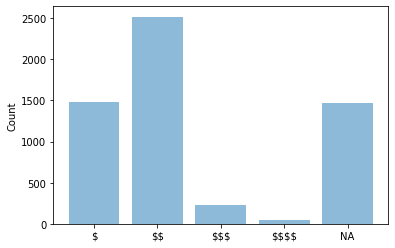

In [2024]:
objects = ("\$", "\$\$", "\$\$\$", "\$\$\$\$", "NA")
y_pos = np.arange(len(objects))

values = [np.sum((data_clean['price'] == "$").values),
          np.sum((data_clean['price'] == "$$").values),
          np.sum((data_clean['price'] == "$$$").values),
          np.sum((data_clean['price'] == "$$$$").values),
          np.sum((data_clean['price'].isna()).values)]

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')



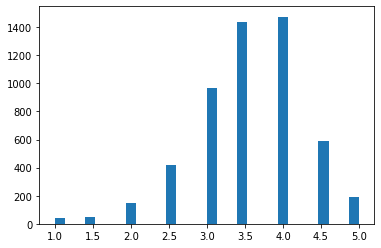

In [2032]:
x = data_clean['rating'].values
plt.hist(x, bins = 30);

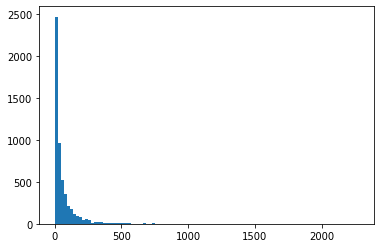

In [2035]:
x = data_clean['review_count'].values
plt.hist(x, bins = 100);

In [2043]:
np.nanmax(x)

2279.0

## Adding more features

In [103]:
# fine closest point for all restaurants to any part of the bikelane 
# need to iterate over all the points, find distance, and minimize 
# bikeways
# find closest point from restaurant to bike lane
# metric will be distance from bikelane

In [106]:
bikeways_df = pd.read_csv('../data/bikeways.csv', sep = ';')

In [107]:
def unlist(cords_list):
    return [cord for cords in cords_list for cord in cords]

In [108]:
bikeways_df = bikeways_df.rename(columns = {'Geom': 'geom'})['geom'].apply(lambda x: eval(x))\
                         .map(lambda x: unlist(x['coordinates']) if x['type'] == 'MultiLineString' else x['coordinates'])

In [109]:
bikeways_list = unlist(bikeways_df.tolist())

In [247]:
def get_dist(rest_cord, cord_list, price = False):
    distances = np.array([])
    for cord in cord_list:
        feature = cord
        rest = rest_cord
        distances = np.append(distances, geodesic(feature[::-1], rest[::-1]).m)
    if price == True:
        return parking_price[distances.argmin()]
    else:
        return distances.min()

In [104]:
# merge rest_distinct_df to data_clean to get long/lat
rest_distinct_df = rest_distinct_df.toPandas()
data_clean = pd.merge(data_clean, rest_distinct_df, on = ['name', 'postal_code', 'unit', 'house', 'street'], how = 'left').drop(columns = ['year', 'status'])
data_clean = data_clean.dropna(subset=['longitude'])

In [105]:
# create list for long/lat to get distance from bike
data_clean['cord'] = data_clean[['longitude', 'latitude']].values.tolist()
data_clean = data_clean.drop(columns = ['longitude', 'latitude'])

In [112]:
# find minimum distance of each restaurant to bike lane
data_clean['distance_from_bike'] = data_clean['cord'].apply(lambda x: get_dist(x, bikeways_list))

In [ ]:
# parking meters
# avg cost

In [216]:
parking_df = pd.read_csv('../data/parking-meters.csv', sep = ';')

In [217]:
parking_cords = parking_df.rename(columns = {'Geom': 'geom'})['geom'].apply(lambda x: eval(x))\
                          .map(lambda x: x['coordinates'])
parking_price = parking_df[['R_MF_9A_6P', 'R_MF_6P_10', 'R_SA_9A_6P', 'R_SA_6P_10', 'R_SU_9A_6P', 'R_SU_6P_10']].replace('\$', '', regex=True).astype(float)
columns = ['R_MF_9A_6P', 'R_MF_6P_10', 'R_SA_9A_6P', 'R_SA_6P_10', 'R_SU_9A_6P', 'R_SU_6P_10']
parking_price['avg_price'] = parking_price[columns].sum(axis=1) / len(columns)
parking_price = parking_price['avg_price']

In [ ]:
data_clean['distance_from_meter'] = data_clean['cord'].apply(lambda x: get_dist(x, parking_cords))

In [249]:
data_clean['avg_meter_price'] = data_clean['cord'].apply(lambda x: get_dist(x, parking_cords, price = True))

In [253]:
path = '../data/'
filename = 'data_cleaned' + time.strftime('_%Y-%m-%d') + '.pkl'
with open(path + filename, 'wb') as f:
    pickle.dump(data_clean, f, pickle.HIGHEST_PROTOCOL)

## Merging Back to the Original Dataframe

> Here I will create a PySpark dataframe to eventually join it back to the `rest_distinct_df` dataframe.

In [1063]:
licences_rest_df = licences_rest_df.toPandas()

In [1068]:
licences_rest_info = pd.merge(data_clean, licences_rest_df, on = ['name', 'postal_code', 'unit', 'house', 'street'], how = 'left')

> quantify similarity of restaurant cuisines to see how similar restuarants in the same proximity do